In [29]:
%matplotlib inline

%matplotlib notebook

from imports import *
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation
np.set_printoptions(suppress=True)

In [24]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [25]:
source = '/home/sobolev/nevermind/Andrey/data'
#source  = '/home/andrey/projects/data/'

session = '008229_hippoSIT_2022-05-17_21-44-43'
animal  = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5name  = os.path.join(source, animal, session, session + '.h5')

In [26]:
s_rate = 100 # Hz

with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result

In [27]:
# smooth speed
width = 500  # 100 points ~= 1 sec with at 100Hz
kernel = signal.gaussian(width, std=(width) / 7.2)
s_smooth = np.convolve(tl[:, 3], kernel, 'same') / kernel.sum()

# sounds
idxs_target = np.where(tl[:, 6] == 2)[0]
idxs_backgr = np.where(tl[:, 6] == 1)[0]
idxs_noise  = np.where(tl[:, 6] ==-1)[0]
idxs_reward = trials[trials[:, 5] == 1][:, 1].astype(np.int32)

# target onsets
min_dur = 0  # min duration in target, sec
idxs_to_idx1 = np.where(np.diff(idxs_target) > 5)[0] + 1 # target starts
idxs_to_idx2 = np.where(np.diff(idxs_target) > 5)[0][1:] # target ends
idxs_to_idx  = np.where(idxs_to_idx2 - idxs_to_idx1[:-1] > min_dur * 100)[0]
idxs_tgt_start = idxs_target[:-1][idxs_to_idx1[idxs_to_idx]]

<IPython.core.display.Javascript object>


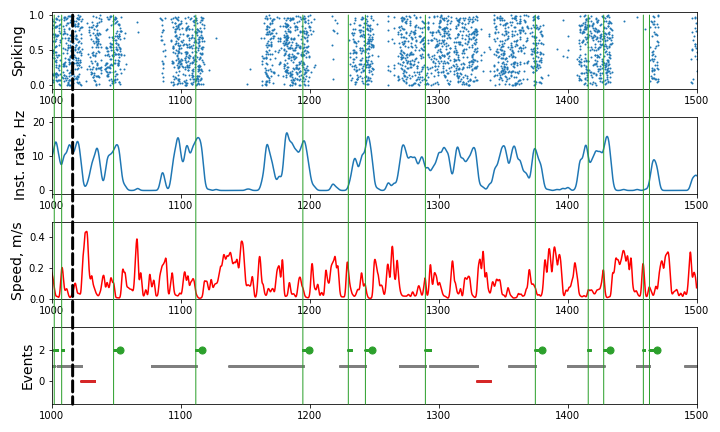

In [45]:
unit_names = ['8-8']

t1, t2 = 1000, 1500

fig = plt.figure(figsize=(10, len(unit_names)*4 + 2))
axes = []
for i, unit_name in enumerate(unit_names):
    with h5py.File(h5name, 'r') as f:
        s_times = np.array(f['units'][unit_name][H5NAMES.spike_times['name']])
        i_rate = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])
    values = np.random.rand(len(s_times))
    
    ax = fig.add_subplot(len(unit_names)*2 + 2, 1, 2*i+1)
    ax.scatter(s_times, values, s=1)
    ax.set_xlim(t1, t2)
    ax.set_ylabel('Spiking', fontsize=14)
    axes.append(ax)
    
    ax2 = fig.add_subplot(len(unit_names)*2 + 2, 1, 2*i+2)
    ax2.plot(tl[:, 0], i_rate)
    ax2.set_xlim(t1, t2)
    ax2.set_ylabel('Inst. rate, Hz', fontsize=14)
    #ax2.axhline(0.4)

ax_s = fig.add_subplot(len(unit_names)*2 + 2, 1, len(unit_names)*2 + 1)
ax_s.plot(tl[:, 0], s_smooth, color='red')
ax_s.set_xlim(t1, t2)
ax_s.set_ylim(0, .5)
ax_s.set_ylabel('Speed, m/s', fontsize=14)

ax_t = fig.add_subplot(len(unit_names)*2 + 2, 1, len(unit_names)*2 + 2)
ax_t.scatter(tl[idxs_target][:, 0], 2*np.ones(len(idxs_target)), s=1, color=COLORS[2])
ax_t.scatter(tl[idxs_backgr][:, 0], np.ones(len(idxs_backgr)), s=1, color=COLORS[4])
ax_t.scatter(tl[idxs_noise][:, 0],  np.zeros(len(idxs_noise)),  s=1, color=COLORS[3])
ax_t.scatter(tl[idxs_reward][:, 0], 2 * np.ones(len(idxs_reward)), s=50, color=COLORS[2])
ax_t.set_xlim(t1, t2)
ax_t.set_ylim(-1.5, 3.5)
ax_t.set_ylabel('Events', fontsize=14)

# vertical lines for events
to_plot = [idxs_tgt_start]
colors = [COLORS[2], COLORS[2], COLORS[3], COLORS[2]]

for j, idxs_var in enumerate(to_plot):
    xy1 = np.vstack([ tl[idxs_var][:, 0],  1.0 * np.ones(len(idxs_var)) ]).T
    xy3 = np.vstack([ tl[idxs_var][:, 0], -1.5 * np.ones(len(idxs_var)) ]).T
    for i in range(len(idxs_var)):
        if xy1[i][0] < t1 or xy1[i][0] > t2:
            continue
        con = ConnectionPatch(xyA=xy1[i], coordsA=axes[0].transData, xyB=xy3[i], coordsB=ax_t.transData, color=colors[j])
        fig.add_artist(con)
        
# time animation line
# https://matplotlib.org/stable/gallery/animation/multiple_axes.html#sphx-glr-gallery-animation-multiple-axes-py
# https://stackoverflow.com/questions/31252107/how-to-draw-vertical-lines-interactively-in-matplotlib
anim_line = ConnectionPatch(xyA=[50, 1], coordsA=axes[0].transData, xyB=[50, -1.5], \
                            coordsB=ax_t.transData, color='black')
anim_line.set(lw=3, ls='--')
fig.add_artist(anim_line)
fig.tight_layout()

def animate(t):
    anim_line.xy1 = (t, 1)
    anim_line.xy2 = (t, -1.5)
    return anim_line

ani = animation.FuncAnimation(fig, animate, interval=50, blit=False, frames=np.linspace(t1, t2, 2000), repeat_delay=100)

ani.save('/home/sobolev/Downloads/%s_%s_5x_w10.mp4' % (t1, t2), writer='ffmpeg', fps=20)

#from IPython.display import HTML
#video = ani.to_html5_video()